In [1]:
%run utils
import utils

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from tqdm import trange, tqdm
import seaborn as sns
import os

In [3]:
TEST_FILE = "data/splits/val_inference_both.csv"
training_both = "data/splits/training_set_naip_nlcd_both.csv"
val_both = "data/splits/val_inference_both.csv"
IMAGE_COL = "image_fn"
LABEL_COL = "label_fn"
GROUP_COL = "gropu"
ROW = 3

### What are the dimensions of NAIP/NLCD image?

In [4]:
df = pd.read_csv(TEST_FILE)
a = io.imread(df.loc[3, LABEL_COL])
a.shape

(3880, 3880)

In [5]:
df = pd.read_csv(TEST_FILE)
a = io.imread(df.loc[3, IMAGE_COL])
a.shape

(3880, 3880, 4)

### Are validation images also in the training set?

In [6]:
training_both_df = pd.read_csv(training_both)
val_both_df = pd.read_csv(val_both)
print(f"There are {len(training_both_df)} samples in the training set")
print(f"There are {len(val_both_df)} samples in the val set")

There are 4500 samples in the training set
There are 100 samples in the val set


In [7]:
all_in = True
for i in range(len(val_both_df)):
    if val_both_df.loc[i, "image_fn"] not in training_both_df["image_fn"].tolist():
        print(val_both_df.loc[i, "image_fn"])
        all_in = False
        break
    elif val_both_df.loc[i, "label_fn"] not in training_both_df["label_fn"].tolist():
        print(val_both_df.loc[i, "image_fn"])
        all_in = False
        break
all_in

True

### Reading STAC files

In [8]:
import json
import shutil
import tempfile
from datetime import date
from pathlib import Path

from pystac import Catalog, get_stac_version
from pystac.extensions.eo import EOExtension
from pystac.extensions.label import LabelExtension

In [9]:
root_catalog = Catalog.from_file('data/catalog/catalog.json')
print(f"ID: {root_catalog.id}")
print(f"Title: {root_catalog.title or 'N/A'}")
print(f"Description: {root_catalog.description or 'N/A'}")

ID: 594cb31a-01ea-4da8-965b-dee345c4ce87
Title: N/A
Description: Exported from Groundwork 2022-10-14T22:59:50.745Z for campaign Capstone


In [10]:
print(get_stac_version())

1.0.0


In [11]:
collections = list(root_catalog.get_collections())

print(f"Number of collections: {len(collections)}")
print("Collections IDs:")
for collection in collections:
    print(f"- {collection.id}")

Number of collections: 2
Collections IDs:
- scenes-46cd7f39-c603-4cfa-bfeb-503ea42bd609
- labels-77d57aaf-da86-4f24-9f5c-dbf4c7ebd28d


In [12]:
collection = root_catalog.get_child("scenes-46cd7f39-c603-4cfa-bfeb-503ea42bd609")
assert collection is not None

In [13]:
items = list(root_catalog.get_all_items())

print(f"Number of items: {len(items)}")
for item in items:
    print(f"- {item.id}")

Number of items: 4
- 299852f3-4972-4faf-a385-dacd3e817320
- 420720bf-94c1-4f20-8aa6-6d4daa4ce762
- a4d9c2f2-c09a-4515-b061-4bb854cb4c44
- 0c85e907-3d60-415b-afa7-5fc5f16e69d0


In [14]:
# grab the item which corresponds to 3716_naip-2017 in README.md
item = root_catalog.get_item("a4d9c2f2-c09a-4515-b061-4bb854cb4c44", recursive=True)

In [15]:
item.geometry

{'type': 'Polygon',
 'coordinates': [[[-76.45064833883964, 38.218334674827766],
   [-76.45064837840813, 38.21833499046275],
   [-76.45064837840813, 38.25361421185205],
   [-76.45064833883964, 38.25361452733395],
   [-76.4506479370941, 38.2536145584062],
   [-76.40573305551618, 38.2536145584062],
   [-76.40573265377064, 38.25361452733395],
   [-76.40573261420215, 38.25361421185205],
   [-76.40573261420215, 38.21833499046275],
   [-76.40573265377064, 38.218334674827766],
   [-76.40573305551618, 38.21833464374043],
   [-76.4506479370941, 38.21833464374043],
   [-76.45064833883964, 38.218334674827766]]]}

In [16]:
item.bbox

[-76.45064837840813, 38.21833464374043, -76.40573261420215, 38.2536145584062]

In [17]:
item.datetime

datetime.datetime(2022, 10, 14, 22, 59, 51, 534000, tzinfo=tzutc())

In [18]:
item.collection_id

'labels-77d57aaf-da86-4f24-9f5c-dbf4c7ebd28d'

In [19]:
item.stac_extensions

['https://raw.githubusercontent.com/stac-extensions/label/v1.0.0/json-schema/schema.json']

In [20]:
EOExtension.has_extension(item)

False

In [21]:
LabelExtension.has_extension(item)

False

### Reading geojson

In [22]:
import geopandas

In [23]:
# the labels annotated by Masa for 3716_naip-2013
gdf = geopandas.read_file("data/catalog/labels/data/0c85e907-3d60-415b-afa7-5fc5f16e69d0.geojson")
gdf.head(2)

,id,default,createdAt,createdBy,annotationProjectId,annotationTaskId,geometry
0,0505f576-0c2c-4078-bbac-dd0ede9ccc11,Impervious,2022-10-11 19:03:29.269000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,7bbcd507-8528-4c2f-8af1-4671e5b79943,"MULTIPOLYGON (((-76.45065 38.23535, -76.45041 ..."
1,086cc7ca-6e98-4641-aa2a-6156bcabf956,Tree Canopy,2022-10-10 07:49:28.010000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,75f79271-789a-451e-935a-e9d757dd11d8,"MULTIPOLYGON (((-76.42804 38.23022, -76.42678 ..."


In [24]:
gdf['default'].unique()

array(['Impervious', 'Tree Canopy', 'Low Vegetation', 'Water'],
      dtype=object)

In [25]:
gdf.shape

(123, 7)

In [26]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'WGS84 (lat/lon)')

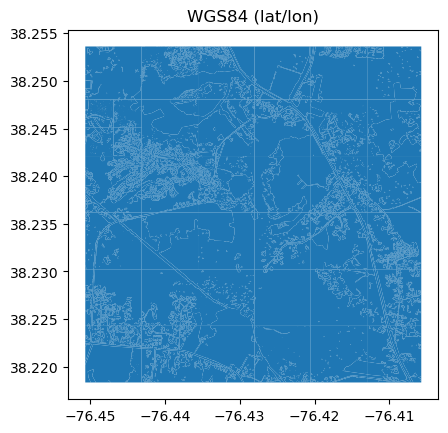

In [27]:
ax = gdf.plot()
ax.set_title("WGS84 (lat/lon)")

<AxesSubplot: >

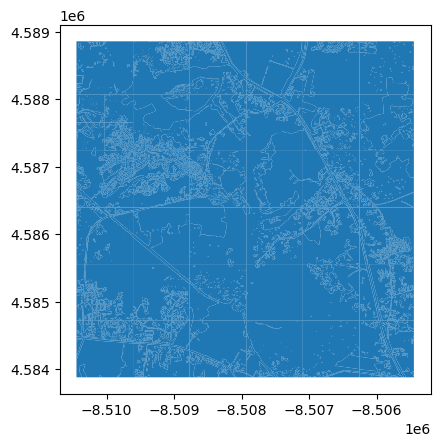

In [28]:
# reproject the original degree-based projection to Mercator
gdf = gdf.to_crs("EPSG:3395")
gdf.plot()

In [29]:
# add an area column
# the area should be in square meters
gdf['area (sq meters)'] = gdf.area
gdf.head(2)

,id,default,createdAt,createdBy,annotationProjectId,annotationTaskId,geometry,area (sq meters)
0,0505f576-0c2c-4078-bbac-dd0ede9ccc11,Impervious,2022-10-11 19:03:29.269000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,7bbcd507-8528-4c2f-8af1-4671e5b79943,"MULTIPOLYGON (((-8510447.251 4586277.893, -851...",31774.809832
1,086cc7ca-6e98-4641-aa2a-6156bcabf956,Tree Canopy,2022-10-10 07:49:28.010000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,75f79271-789a-451e-935a-e9d757dd11d8,"MULTIPOLYGON (((-8507930.673 4585554.896, -850...",550702.822286


In [30]:
# compute the area percentage of all 4 classes
total_area = gdf['area (sq meters)'].sum()
all_classes = gdf['default'].unique()
percentages = []
for c in all_classes:
    gdf_sub = gdf.loc[gdf['default'] == c]
    sub_class_area_perc = gdf_sub['area (sq meters)'].sum() / total_area
    percentages.append(sub_class_area_perc)

Text(0.5, 1.0, 'Area Percentage of 4 Classes in 3716_naip-2013')

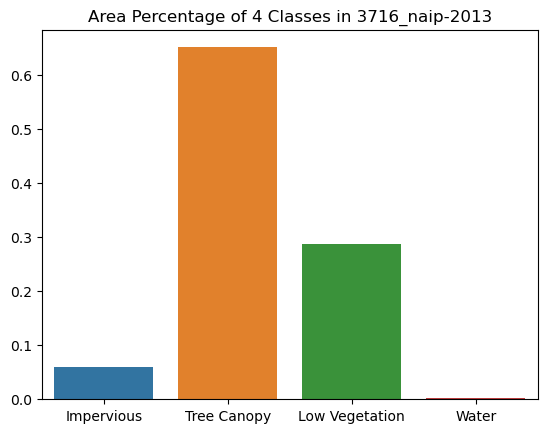

In [31]:
# plot
ax = sns.barplot(x=all_classes, y=percentages)
ax.set_title("Area Percentage of 4 Classes in 3716_naip-2013")

In [60]:
def get_percentages(geojson_path) -> dict:
    gdf = geopandas.read_file(geojson_path)
    gdf = gdf.to_crs("EPSG:3395")
    gdf["area (sq meters)"] = gdf.area
    total_area = gdf['area (sq meters)'].sum()
    all_classes = gdf['default'].unique()
    res = {}
    for c in all_classes:
        gdf_sub = gdf.loc[gdf['default'] == c]
        sub_class_area_perc = gdf_sub['area (sq meters)'].sum() / total_area
        res[c] = sub_class_area_perc
    return res

In [33]:
def get_reduced_class_names(nlcd_label_int) -> str:
    assert nlcd_label_int in utils.NLCD_CLASS.keys()
    for k, v in utils.MAPPING.items():
        if nlcd_label_int in v:
            return k

In [34]:
def create_direct_map():
    res = {}
    for k in utils.NLCD_CLASS.keys():
        for m, n in utils.MAPPING.items():
            if k in n:
                res[k] = m
    return res

In [35]:
def find_image_index(df, image_number, year, col):
    for i in range(len(df)):
        if f"{image_number}_nlcd-{year}" in df.loc[i, col]:
            return i

In [51]:
def calculate_class_percentages(df, image_number, year, col, res) -> dict:
    """Calculate class percentage
    
    Args:
        df: training_both_df
        image_number: str or int, e.g. 3716
        year: str or int, e.g. 2013
        col: str, e.g. "label_fn"
        res: int, e.g. 30 means 30 x 30
    
    Returns:
        dict
    """
    img_index = find_image_index(df, image_number, year, col)
    img = io.imread(df.loc[img_index, col])
    perc_dict = {}
    for m in trange(img.shape[0], desc="1st loop"):
        for n in range(img.shape[1]):
            # "Tree Canopy" / "Water" / ...
            class_label = reduced_map[img[m][n]]
            perc_dict[class_label] = perc_dict.get(class_label, 0) + res ** 2
    for k, v in perc_dict.items():
        perc_dict[k] = v / (img.shape[0] * img.shape[1] * res ** 2)
    return perc_dict

In [52]:
training_both_df = pd.read_csv("data/splits/training_set_naip_nlcd_both.csv")
reduced_map = create_direct_map()
nlcd_percentage_3716_2013 = calculate_class_percentages(training_both_df, "3716", "2013", "label_fn", 30)
nlcd_percentage_3716_2016 = calculate_class_percentages(training_both_df, "3716", "2016", "label_fn", 30)

1st loop: 100%|████████████████████████████████████████████████████████████████████████| 3880/3880 [00:40<00:00, 96.61it/s]


In [61]:
masa_annotated_3716_2013 = get_percentages("data/catalog/labels/data/0c85e907-3d60-415b-afa7-5fc5f16e69d0.geojson")
masa_annotated_3716_2017 = get_percentages("data/catalog/labels/data/a4d9c2f2-c09a-4515-b061-4bb854cb4c44.geojson")

In [62]:
masa_annotated_3716_2013

{'Impervious': 0.05906276881854651,
 'Tree Canopy': 0.6514570110188175,
 'Low Vegetation': 0.28749929564818527,
 'Water': 0.0019809245144506906}

In [96]:
masa_annotated_3716_2017

{'Tree Canopy': 0.6814331121402595,
 'Impervious': 0.05798948817612803,
 'Low Vegetation': 0.25860959215561624,
 'Water': 0.00196780752799619}

In [64]:
nlcd_percentage_3716_2013

{'Tree Canopy': 0.6943465033478584,
 'Low Vegetation': 0.23974080667446063,
 'Impervious': 0.06509445743437135,
 'Water': 0.0008182325433095972}

In [95]:
nlcd_percentage_3716_2016

{'Tree Canopy': 0.6815032814326708,
 'Low Vegetation': 0.25148308800085023,
 'Impervious': 0.0662537198427038,
 'Water': 0.0007599107237751089}

In [109]:
def plot_bars(nlcd_annotation, masa_annotation, image_number, year):
    df = pd.DataFrame.from_records([nlcd_annotation, masa_annotation], 
                                    index=["NLCD", "Masa"])
    df = df.reset_index().rename(columns={"index": "Annotation"})
    df = df.melt(id_vars=["Annotation"], 
                 value_vars=["Tree Canopy", "Low Vegetation", "Impervious", "Water"], 
                 var_name="Class", value_name="Percentage")
    # round to 4 decimal places
    df = df.round({"Percentage": 4})
    ax = sns.barplot(data=df, x="Class", y="Percentage", hue="Annotation")
    ax.set_title(f"Area Percentage Comparison, NLCD vs. Masa's Annotation in {image_number}_naip-{year}")
    # add texts above bars
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.savefig(f"{image_number}_naip-{year}.png",bbox_inches='tight')

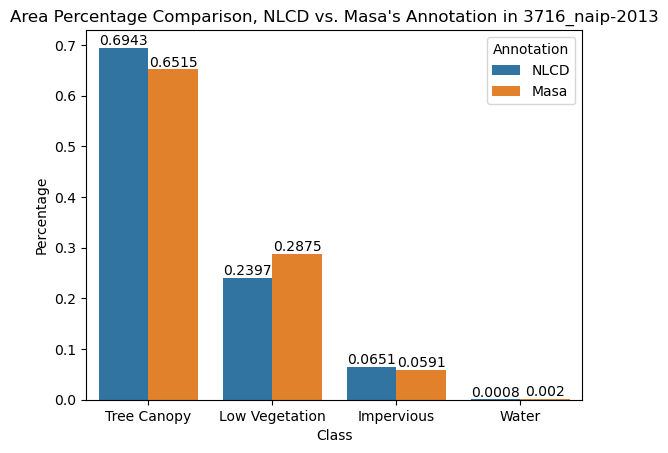

In [110]:
plot_bars(nlcd_percentage_3716_2013, masa_annotated_3716_2013, "3716", "2013")

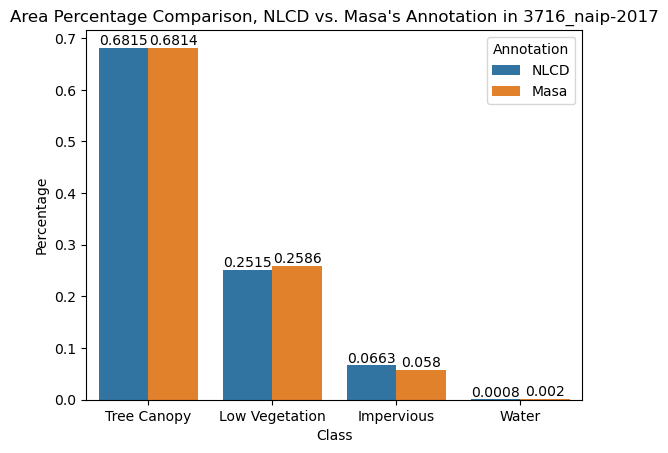

In [111]:
plot_bars(nlcd_percentage_3716_2016, masa_annotated_3716_2017, "3716", "2017")

### Then we could only focus on the training data

In [ ]:
def compute_percentage(df, df_row, img_ndarray) -> None:
    """Do one_pass to fill in df columns"""
    for i in range(img_ndarray.shape[0]):
        for j in range(img_ndarray.shape[1]):
            df.loc[df_row, utils.NLCD_CLASS[img_ndarray[i][j]]] += 1
    for class_name in utils.NLCD_CLASS.values():
        df.loc[df_row, class_name] /= (img_ndarray.shape[0] * img_ndarray.shape[1])

In [ ]:
def transform_df(sample_df) -> pd.DataFrame:
    """Transform training_df or val_df such that it one-hot-encodes 
    the percentage of each class in each image, done for the NLCD column"""
    df_copy = sample_df.copy()
    for v in utils.NLCD_CLASS.values():
        df_copy[v] = 0
    for i in range(len(sample_df)):
        img = io.imread(df_copy.loc[i, "label_fn"])
        compute_percentage(df_copy, i, img)
    return df_copy

In [ ]:
def plot_histogram_one_class(sample_df, class_int):
    """Plot distribution of a certain class throughout samples
    
    Args:
        sample_df: either training_df or val_df
        class_int: the integer representing the class
    """
    

In [ ]:
df_copy = training_both_df.copy()
for v in utils.NLCD_CLASS.values():
    df_copy[v] = 0
for i in trange(len(df_copy)):
    img = io.imread(df_copy.loc[i, "label_fn"])
    compute_percentage(df_copy, i, img)
df_copy.to_csv("training_both_encoded.csv")

In [ ]:
# plot a distribution of the percentage of a certain class in a certain image
